## データの取得・確認

In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path('__file__').resolve().parent.parent.parent.parent))

import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import model_selection
from termcolor import cprint

from src.modules.scripts.evaluation import score

boston = datasets.load_boston()
boston_data = pd.DataFrame(data=boston.data, columns=boston.feature_names)
boston_target = pd.Series(data=boston.target, name='target')

X_train, X_test, y_train, y_test = model_selection.train_test_split(boston_data, boston_target)

cprint('Boston Data (samples: {}, features: {})'.format(*boston_data.shape), 'blue', attrs=['bold'])
cprint('Boston Target (samples: {})'.format(*boston_target.shape), 'blue', attrs=['bold'])


Boston Data (samples: 506, features: 13)
Boston Target (samples: 506)


In [2]:
boston_data.head(3)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03


In [3]:
boston_target.head(3)


0    24.0
1    21.6
2    34.7
Name: target, dtype: float64

|  データセット  |  説明  |
| ---- | ---- |
|  CRIM  |  犯罪発生率（人口単位）  |
|  ZN  |  25,000平方フィート以上の住宅区画の割合  |
|  INDUS  |  非小売業の土地面積の割合（人口単位）  |
|  CHAS  |  チャールズ川沿いかどうか（1:Yes、0:No）  |
|  NOX  |  窒素酸化物の濃度（pphm単位）  |
|  RM  |  1戸あたりの平均部屋数  |
|  AGE  |  1940年よりも前に建てられた家屋の割合  |
|  DIS  |  5つのボストン市の雇用施設からの距離  |
|  RAD  |  環状高速道路へのアクセスしやすさ  |
|  TAX  |  $10,000 ドルあたりの不動産税率の総計  |
|  PTRATIO  |  教師あたりの生徒の数（人口単位）  |
|  B  |  アフリカ系アメリカ人居住者の割合（人口単位）  |
|  LSTAT  |  低所得者の割合  |
|  TARGET  |  目的変数／住宅価格  |

## データの可視化

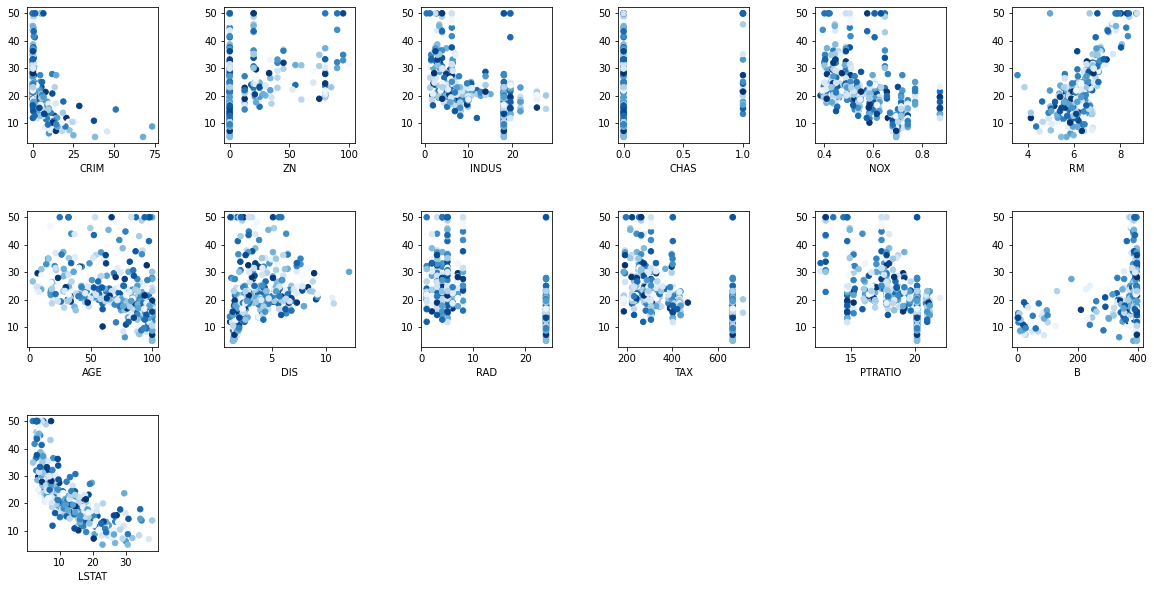

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# 特徴量と住宅価格（ターゲット）の相関
fig = plt.figure(figsize=(20, 10))
color = np.random.choice(np.arange(100), len(X_train))
for i in range(len(X_train.columns)):
    ax = fig.add_subplot(3, 6, i + 1)
    ax.set_xlabel(X_train.columns[i])
    ax.scatter(X_train.iloc[:, i], y_train, c=color, cmap='Blues', s=30)

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()


### 上図から考察したこと
- 犯罪発生率が高いところは物件価格が安い
- チャールズ川沿いの物件は少ないが、物件価格に違いはない
- 平均部屋数が多いと物件価格が高くなる
- 1940年よりも前に建てられた家屋の割合が高いと物件価格が安くなる
- アフリカ系アメリカ人居住者の割合が高い
- 低所得者の割合が高いと物件価格が安くなる
- 不動産税率が安いほうが所有物件自体の価格は高くなる傾向がある

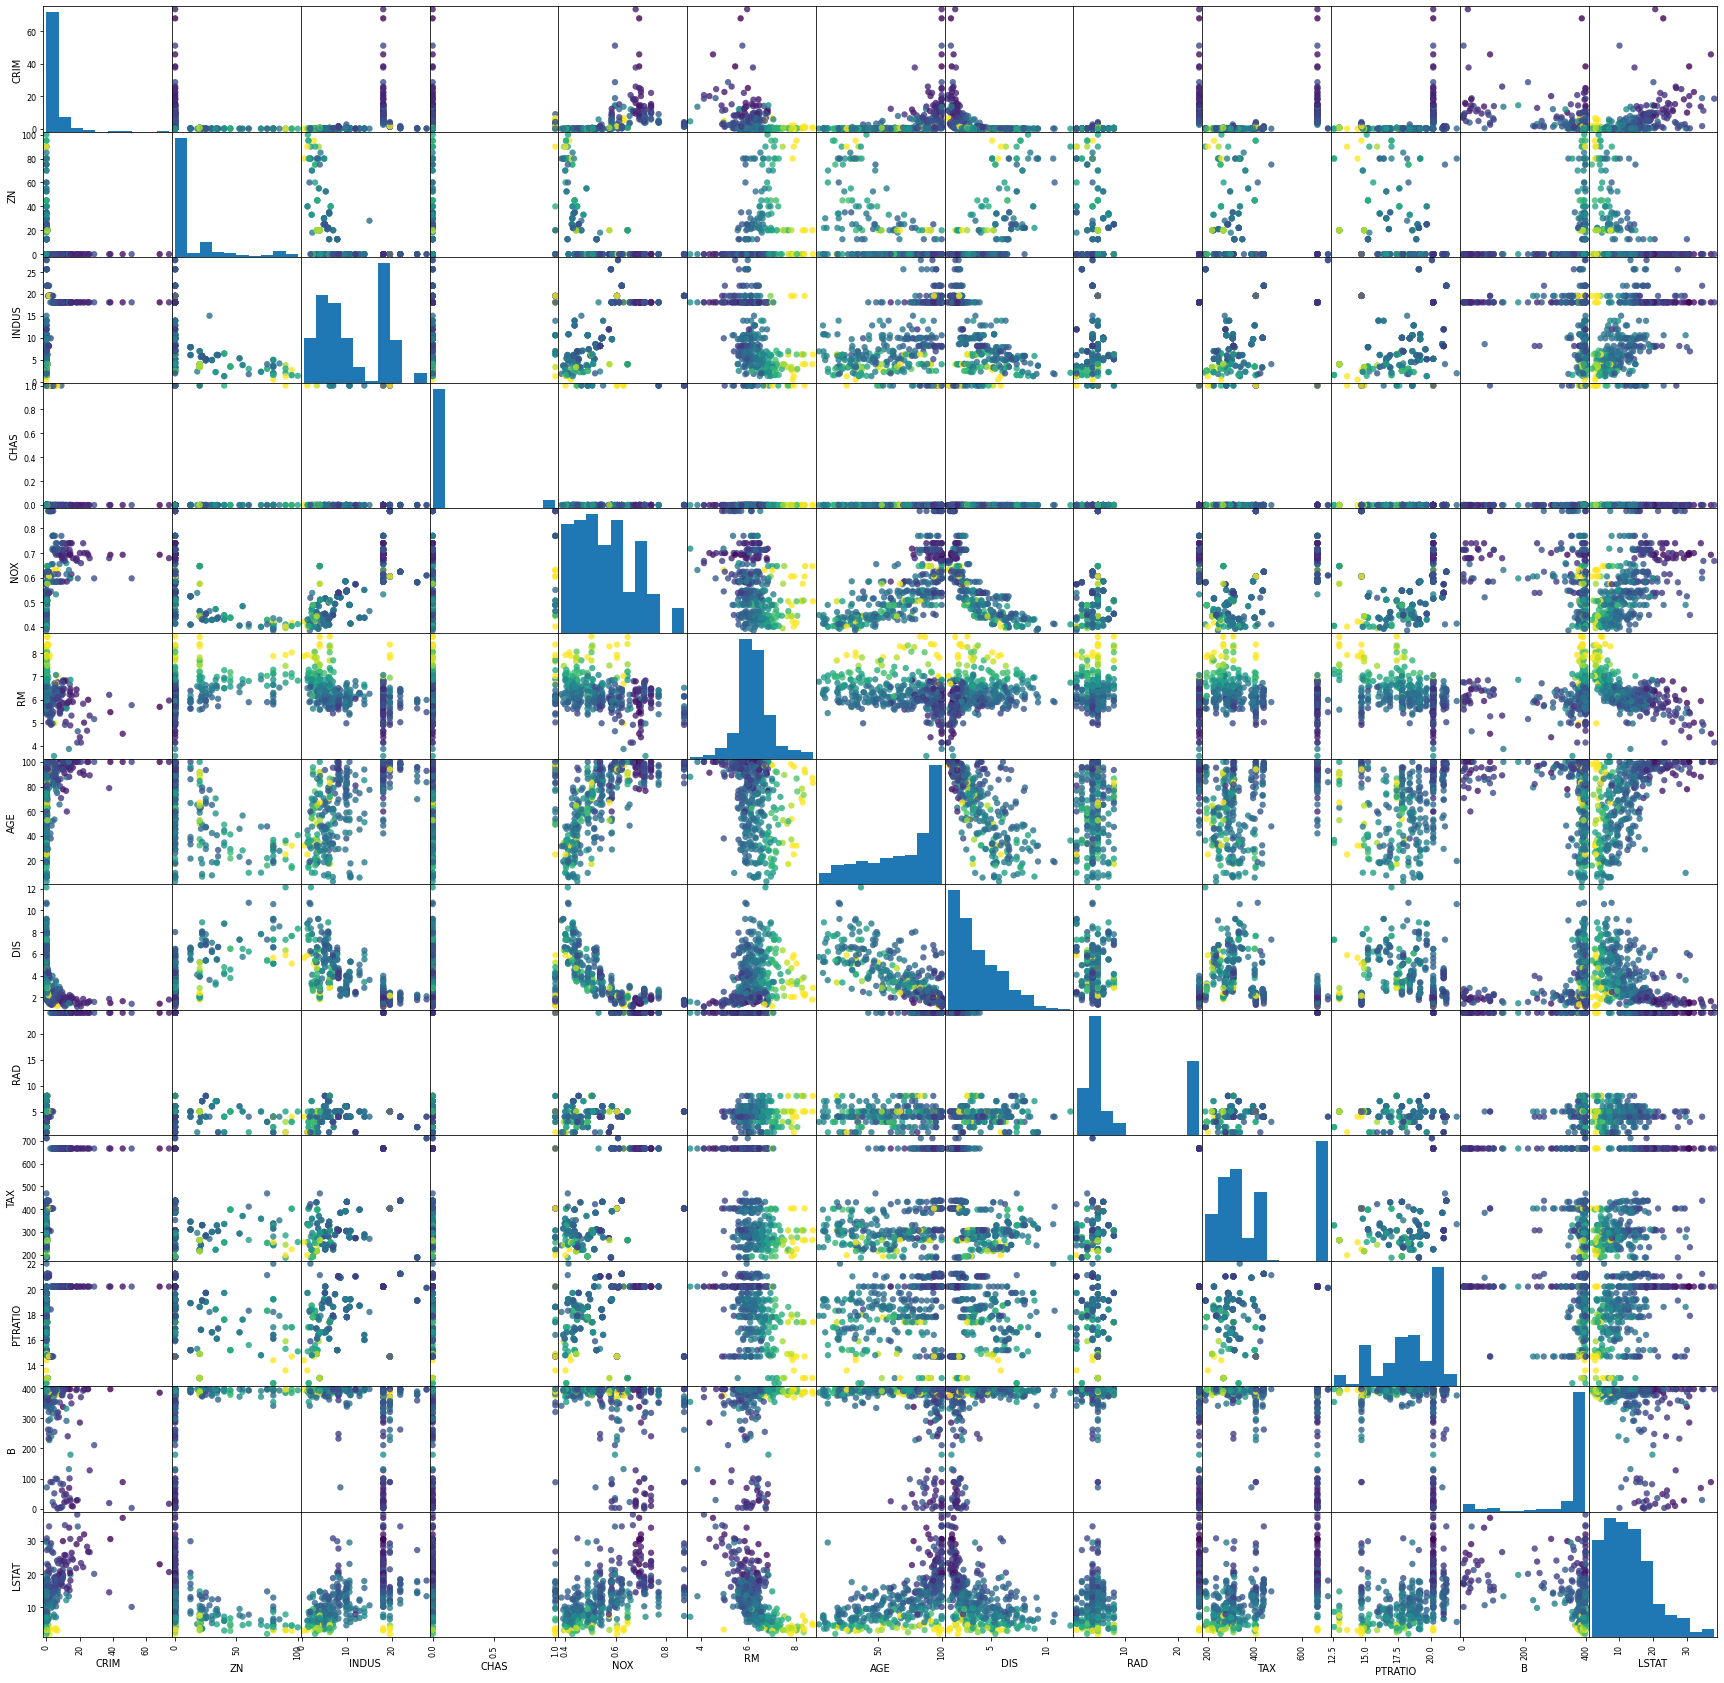

In [5]:
from pandas.plotting import scatter_matrix

# 特徴量の相関をプロット
scatter_matrix(X_train, c=y_train, figsize=(30, 30), marker='o', hist_kwds={'bins': 10}, s=40, alpha=.8)
plt.show()


## データ前処理

In [6]:
def standardize(X):
    """標準化する.
    
    X: データセット
    """
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)


def add_ones(X):
    """特徴量の0列目に1を加える.
    
    X: データセット
    """
    X['0'] = 1
    return X.sort_index(axis=1, ascending=True)


def add_square_features(X, features):
    """特徴量を二乗したものを新しい特徴量として追加する.
    
    X: データセット
    features: 二乗して追加する特徴量
    """
    square_features = pd.DataFrame(features ** 2).rename(columns=lambda column: column + '_SQUARE')
    return pd.concat([X, square_features], axis=1)


def add_cross_feature(X, column, feature1, feature2):
    """特徴量と特徴量を掛け合わせたものを新しい特徴量として追加する.
    
    X: データセット
    column: 新しいカラム名
    feature1: 掛け合わせる特徴量1つ目
    feature2: 掛け合わせる特徴量2つ目
    """
    X[column] = pd.Series(feature1 * feature2)
    return X


# 学習不足になるため多項変数を追加
X_train = add_square_features(X_train, X_train)
X_test = add_square_features(X_test, X_test)

# LSTATと相関がみられる特徴量が多いため掛け合わせて新しい特徴量にする
for column in X_train.columns:
    X_train = add_cross_feature(X_train, 'LSTAT_{}'.format(column), X_train.loc[:, 'LSTAT'], X_train.loc[:, column])
    X_test = add_cross_feature(X_test, 'LSTAT_{}'.format(column), X_test.loc[:, 'LSTAT'], X_test.loc[:, column])

X_train_std = standardize(X_train)
X_test_std = standardize(X_test)

# バイアス項を追加
X_train_std = add_ones(X_train_std)
X_test_std = add_ones(X_test_std)

X_train_std.head(3)


,0,AGE,AGE_SQUARE,B,B_SQUARE,CHAS,CHAS_SQUARE,CRIM,CRIM_SQUARE,DIS,...,PTRATIO,PTRATIO_SQUARE,RAD,RAD_SQUARE,RM,RM_SQUARE,TAX,TAX_SQUARE,ZN,ZN_SQUARE
265,1,-0.242622,-0.492255,0.416887,0.465320,-0.260011,-0.260011,-0.351196,-0.187983,-0.850166,...,-2.488310,-2.284055,-0.532200,-0.594387,-0.969461,-0.948073,-0.863058,-0.804695,0.380708,-0.144552
15,1,-0.467343,-0.711626,0.448876,0.521438,-0.260011,-0.260011,-0.367626,-0.188425,0.361105,...,1.197895,1.280691,-0.645836,-0.630975,-0.588207,-0.609790,-0.608492,-0.648827,-0.479046,-0.362474
303,1,-1.851340,-1.551924,0.397317,0.431214,-0.260011,-0.260011,-0.432178,-0.189334,0.839953,...,-1.059906,-1.101791,-0.304928,-0.496819,1.009163,0.984425,-0.478249,-0.560002,0.982536,0.267322


## モデルの構築・訓練

In [7]:
class LinearRegression(object):
    """勾配降下法に基づく線形回帰."""

    def __init__(self, alpha=0.01, eps=1e-4):
        """
        
        ---パラメータ-------
        alpha: 学習率
        eps: 収束の目安
        --------------------
        
        ---属性-------------
        _w: パラメータ（重み）
        _n_iter: 訓練回数
        _error_list: 二乗和誤差のリスト
        _grad_list: 勾配のリスト
        --------------------
        
        """
        self.alpha = alpha
        self.eps = eps

        self._w = 0
        self._n_iter = 0
        self._error_list = []
        self._grad_list = []

    def fit(self, X, y):
        """訓練データで学習する.
        
        ---パラメータ-------
        X: 訓練データセット
        y: ターゲット
        --------------------
        
        """
        # パラメータの初期値はランダムに設定する
        theta = np.random.rand(X.shape[1])
        error = self.J(X, y, theta)
        diff = 1

        # コスト関数の値が殆ど変動しなくなったら収束とする
        while diff > self.eps:
            # パラメータの更新処理
            grad = (1 / len(y)) * np.dot(self.h(X, theta) - y, X)
            theta = theta - self.alpha * grad

            # 収束状況を確認するための処理
            current_error = self.J(X, y, theta)
            diff = error - current_error
            error = current_error
            print('\r【{}回目】Error: {}, Diff: {}, Grad: {}'.format(self._n_iter + 1, error, diff, grad.sum()), end='')

            self._error_list.append(error)
            self._grad_list.append(grad.sum())
            self._n_iter += 1

        self._w = theta
        return self

    def predict(self, X):
        """ターゲットを予測する.
        
        X: テストデータセット
        """
        return np.dot(X, self._w)

    def h(self, X, theta):
        """仮説関数.
    
        X: 訓練データセット
        theta: パラメータ（重み）
        """
        return np.dot(X, theta.T)

    def J(self, X, y, theta):
        """目的関数（二乗和誤差）.
        
        X: 訓練データセット
        y: ターゲット
        theta: パラメータ（重み）
        """
        return (1 / (2 * len(y))) * np.sum((self.h(X, theta) - y) ** 2)


In [8]:
lr = LinearRegression()
lr.fit(X_train_std, y_train)


【156回目】Error: 18.70127999823606, Diff: 0.21770923093621164, Grad: -3.732531496126504

【307回目】Error: 7.884954377197379, Diff: 0.014939501435909719, Grad: -0.8372214372201928

【464回目】Error: 6.843053873061603, Diff: 0.0030914744376664416, Grad: -0.2002961543158612

【618回目】Error: 6.498375719857743, Diff: 0.00169588782872232, Grad: -0.06935307542405275

【767回目】Error: 6.288514699239218, Diff: 0.001179560302109195, Grad: -0.03642000076406011

【925回目】Error: 6.128845392511804, Diff: 0.0008698531885009686, Grad: -0.022137985639196597

【1080回目】Error: 6.009855082866501, Diff: 0.0006804087793659264, Grad: -0.013161121722830247

【1235回目】Error: 5.914798597153686, Diff: 0.0005550963306264478, Grad: -0.006278004911369775

【1394回目】Error: 5.834004542458841, Diff: 0.0004670799782200419, Grad: -0.0007934641392794012

【1547回目】Error: 5.767415414655001, Diff: 0.0004069440784348899, Grad: 0.0032300987263144416

【1705回目】Error: 5.706927106789148, Diff: 0.0003612619402302286, Grad: 0.006325652754799491

【1862回目】Error: 5.653042512294244, Diff: 0.0003268693817162216, Grad: 0.008550436271832768

【2021回目】Error: 5.603334918957225, Diff: 0.0002995966488796853, Grad: 0.010130140708122572

【2174回目】Error: 5.5591856615465005, Diff: 0.0002783348743538028, Grad: 0.011157859919215942

【2331回目】Error: 5.5169661427291965, Diff: 0.00026012484423265647, Grad: 0.011829919974124841

【2490回目】Error: 5.476895470563616, Diff: 0.0002443970483705371, Grad: 0.012211948718608472

【2640回目】Error: 5.441234295366216, Diff: 0.00023143556292293255, Grad: 0.012365434927972237

【2798回目】Error: 5.405650442975164, Diff: 0.00021929905375550618, Grad: 0.012365443145735261

【2957回目】Error: 5.371674294332988, Diff: 0.00020832836764927976, Grad: 0.01224221834049042

【3115回目】Error: 5.33955754860039, Diff: 0.00019842548948112437, Grad: 0.012031558596194857

【3274回目】Error: 5.308748650134058, Diff: 0.00018929272139711628, Grad: 0.011757092423982513

【3430回目】Error: 5.279876563846806, Diff: 0.00018102029800193264, Grad: 0.01144624351979734

【3589回目】Error: 5.251728005893955, Diff: 0.00017319381822389346, Grad: 0.011101999534639967

【3745回目】Error: 5.225277994790893, Diff: 0.0001660354531285435, Grad: 0.010748314611720777

【3901回目】Error: 5.199908098409984, Diff: 0.00015933464807904585, Grad: 0.010386968232059219

【4057回目】Error: 5.175550744884739, Diff: 0.00015304438501040352, Grad: 0.010023937984018991

【4215回目】Error: 5.151850914644469, Diff: 0.00014705183678831446, Grad: 0.00965901303326297

【4362回目】Error: 5.130627321122105, Diff: 0.00014178821354882132, Grad: 0.00932485188884318

【4519回目】Error: 5.108790605362198, Diff: 0.0001364705886128803, Grad: 0.008975814050809473

【4672回目】Error: 5.088291559620264, Diff: 0.0001315667890988692, Grad: 0.008644916444641156

【4814回目】Error: 5.0699207225831975, Diff: 0.00012724297684574282, Grad: 0.008346798036193384

【4972回目】Error: 5.05018301898248, Diff: 0.00012267074373273346, Grad: 0.008025810079999734

【5128回目】Error: 5.031385604601207, Diff: 0.00011838582225731642, Grad: 0.007720239920090488

【5280回目】Error: 5.013697204197894, Diff: 0.00011441480762197642, Grad: 0.007433411601556478

【5435回目】Error: 4.996266109264718, Diff: 0.00011055889201472269, Grad: 0.007151902424194098

【5590回目】Error: 4.979418278029155, Diff: 0.00010688560870075747, Grad: 0.006881260203409987

【5750回目】Error: 4.9626097419953865, Diff: 0.00010327301934687227, Grad: 0.006612966631425814

【5902回目】Error: 4.947164586603947, Diff: 9.999909036206844e-05, Grad: 0.006368162544211511

## 予測・評価

In [9]:
predict = pd.DataFrame(lr.predict(X_train_std), columns=['target'])
predict.head()


,target
0,25.839571
1,18.546042
2,32.833854
3,20.337710
4,19.316903


In [10]:
train_score = score(predict, y_train, 'r2')
test_score = score(pd.DataFrame(lr.predict(X_test_std), columns=['target']), y_test, 'r2')
cprint('train_score: {}\ntest_score: {}'.format(train_score, test_score), 'red', attrs=['bold'])


train_score: 0.8870221002675103
test_score: 0.6884466812242808


## 結果を可視化

### 繰り返し回数と二乗和誤差・勾配それぞれの相関

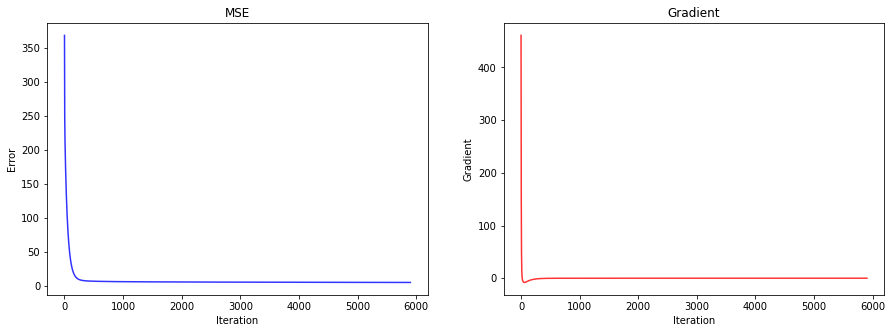

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(1, 2, 1)
ax.set_title('MSE')
ax.set_ylabel('Error')
ax.set_xlabel('Iteration')
ax.plot(np.arange(lr._n_iter), lr._error_list, color='b', alpha=0.8)

ax = fig.add_subplot(1, 2, 2)
ax.set_title('Gradient')
ax.set_ylabel('Gradient')
ax.set_xlabel('Iteration')
ax.plot(np.arange(lr._n_iter), lr._grad_list, color='r', alpha=0.8)

plt.show()


### ランダム・学習済みのパラメータを設定した場合のそれぞれの予測値

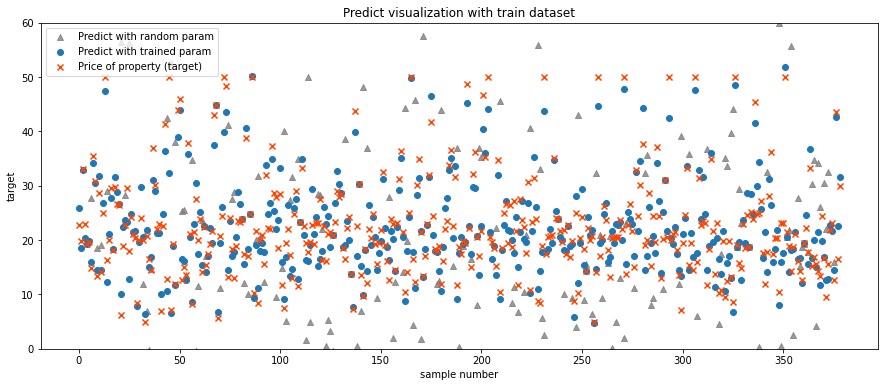

In [12]:
plt.figure(figsize=(15, 6))
plt.scatter(range(len(X_train_std)), lr.h(X_train_std, np.ones([X_train_std.shape[1]])),
            label='Predict with random param', alpha=0.8, color='0.5', marker='^')
plt.scatter(range(len(X_train_std)), lr.h(X_train_std, lr._w), label='Predict with trained param', marker='o')
plt.scatter(range(len(y_train)), y_train, label='Price of property (target)', color='orangered', marker='x')
plt.title('Predict visualization with train dataset')
plt.xlabel('sample number')
plt.ylabel('target')
plt.ylim(0, 60)
plt.legend(loc='upper left')
plt.show()
